# Hannah Zhao - Week 2 DenseNet Model with MIL
## MIL (Multiple Instance Learning) stops you from punishing for “normal‐looking” patches in High-grade cases by moving supervision up to the case level
#### changes include: using TransMIL & self-learned attention & adaptive pooling adjustments & training on only handful of cases
##### 1. patch feature extraction (adaptive pooling currently turning it into a single feature vector), 2. transformer encoder, 
#### overall results:  validation accuracy is very bad.. needs more adjustments, however cannot tell if it's my model's issue or if it's the data issue...
#### next step: testing a simple MIL model to see if accuracy at the core is able to be good

In [1]:
# Standard library imports
import os
import re
import random
import shutil
from datetime import datetime
from collections import OrderedDict

# Data handling and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and TorchVision libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.models as models
from torchvision import transforms, datasets
from PIL import Image

# Scikit-Learn for evaluation metrics and data splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Imbalanced-learn for oversampling to address class imbalance
from imblearn.over_sampling import RandomOverSampler

from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
from PIL import Image
from PIL import UnidentifiedImageError
from tqdm import tqdm


In [2]:
# Define local file paths

# Define your Desktop folder based on your OS; this uses the user's home directory.
desktop = os.path.join(os.path.expanduser("~"), "Desktop")

# Path to the filtered patches folder on your Desktop
filtered_patches_dir = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "CMIL_SP2025_Patches_Apr16")

# Path to the CSV file inside Desktop/uni/STAT 390/Hannah Zhao
csv_file_path = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "case_grade_match.csv")

# Directory to store model checkpoints
checkpoint_dir = os.path.join(desktop, "uni", "STAT 390", "Hannah Zhao", "Checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)  # Create the directory if it doesn't exist

# load labels 
labels = pd.read_csv(csv_file_path)

In [3]:
# === Helper: group patches
def group_patches(patch_dir):
    case_patches = {}
    for filename in os.listdir(patch_dir):
        match = re.search(r"case_(\d+)", filename)
        if match:
            case_num = int(match.group(1))
            if case_num not in case_patches:
                case_patches[case_num] = []
            case_patches[case_num].append(os.path.join(patch_dir, filename))
    return case_patches

patches = group_patches(filtered_patches_dir)

# Validation / Test transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Training transform (augmented)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [4]:
# Prepare case split
case_nums = list(patches.keys())
dataset = labels.loc[[(x-1) for x in case_nums]]  # Adjust indexing
valid_classes = [1.0, 3.0, 4.0]
filtered_dataset = dataset[dataset['Class'].isin(valid_classes)]

X = filtered_dataset.Case.reset_index(drop=True)
y = filtered_dataset.Class.reset_index(drop=True)


#Benign: 2, 21, 22, 25, 34, 45, 53, 77, 78, 79, 85, 90
#High grade: 1, 3, 9, 12, 38, 49, 55, 60, 62, 70, 89, 92, 98, 99

# === No train_test_split ===
train_cases = [77, 34, 89, 9]  # 1 benign + 1 high-grade, 84 -- high grade, 86 -- benign
val_cases = [78, 1, 2, 92]        # 1 benign
test_cases = [3, 79]        # 1 high-grade

train_patches = {c: patches[c] for c in train_cases}
val_patches = {c: patches[c] for c in val_cases}
test_patches = {c: patches[c] for c in test_cases}

# Optional: filter to just H&E stain
def filter_by_stain(d, keyword):
    out = {}
    for c, paths in d.items():
        f = [p for p in paths if keyword.lower() in os.path.basename(p).lower()]
        if f:
            out[c] = f
    return out

stain = "h&e"
train_patches = filter_by_stain(train_patches, stain)
val_patches = filter_by_stain(val_patches, stain)
test_patches = filter_by_stain(test_patches, stain)

In [5]:
class MILDataset(Dataset):
    def __init__(self, case_patches, labels_df, transform=None, emergency_cap=800):
        self.transform = transform
        self.emergency_cap = emergency_cap  # only cap if massive
        self.bags, self.labels = [], []
        for case, paths in case_patches.items():
            raw = labels_df.loc[labels_df['Case'] == case, 'Class'].item()
            bag_lbl = 0 if raw == 1 else 1
            self.bags.append(paths)
            self.labels.append(bag_lbl)

    def __len__(self): return len(self.bags)

    def __getitem__(self, idx):
        paths = self.bags[idx]
        imgs = []
        for p in paths:
            try:
                img = Image.open(p).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                imgs.append(img)
            except:
                continue

        if len(imgs) == 0:
            raise ValueError(f"No good patches in case {paths}")

        # Only sample if emergency_cap is set
        if self.emergency_cap is not None and len(imgs) > self.emergency_cap:
            imgs = random.sample(imgs, self.emergency_cap)

        return torch.stack(imgs), torch.tensor(self.labels[idx], dtype=torch.long)



class AttentionPool(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        # x shape: (B, M, D)
        weights = self.attention(x)  # (B, M, 1)
        weights = torch.softmax(weights, dim=1)  # softmax across patches
        weighted_x = (weights * x).sum(dim=1)    # weighted sum of patches
        return weighted_x
    

class TransMIL(nn.Module):
    def __init__(self, base_model, num_classes=2, embed_dim=512, num_heads=8, num_layers=2):
        super().__init__()
        self.features = base_model.features
        self.pool = nn.AdaptiveAvgPool2d((2,2))
        self.patch_projector = nn.Linear(base_model.classifier.in_features * 4, embed_dim)
        self.attention_pool = AttentionPool(embed_dim)
        
        # self-attention happens — each patch learns which other patches are important to it, happening internally
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        if x.dim() == 4:
            x = x.unsqueeze(0)
        B, M, C, H, W = x.shape
        x = x.view(B*M, C, H, W)

        features = self.features(x)
        pooled = self.pool(features).view(B*M, -1)
        embeddings = self.patch_projector(pooled)
        embeddings = embeddings.view(B, M, -1)  # (batch, sequence, embed_dim)

        transformer_out = self.transformer(embeddings)  # No permute needed

        bag_emb = self.attention_pool(transformer_out)  # replace mean pooling with the learned attention
        logits = self.classifier(bag_emb)

        return logits


In [6]:
# Set up datasets
train_ds = MILDataset(train_patches, labels, transform=train_transform, emergency_cap=250)
val_ds   = MILDataset(val_patches,   labels, transform=transform, emergency_cap=250)
test_ds  = MILDataset(test_patches,  labels, transform=transform, emergency_cap=None)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False)

In [7]:
def save_checkpoint(model, arch, checkpoint_dir, optimizer, epoch):
    os.makedirs(checkpoint_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{checkpoint_dir}/{timestamp}_{arch}_epoch{epoch}.pth"
    checkpoint = {
        "arch": arch,
        "model_state_dict": model.state_dict(),
        "epoch": epoch,
        "optimizer_state_dict": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)
    print(f"✅ Checkpoint saved: {filename}")

def validation(model, criterion, val_loader):
    val_loss = 0
    correct_total = 0
    sample_total = 0
    model.eval()
    with torch.no_grad():
        for bags, labels in val_loader:
            bags = bags.to(device)
            labels = labels.to(device)
            outputs = model(bags)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct_total += (preds == labels).sum().item()
            sample_total += labels.size(0)
    return val_loss / sample_total, correct_total / sample_total

def train_model(model, optimizer, criterion, train_loader, val_loader, arch, checkpoint_dir, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for bags, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            bags = bags.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(bags)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        val_loss, val_acc = validation(model, criterion, val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader):.3f}, Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}")
        save_checkpoint(model, arch, checkpoint_dir, optimizer, epoch+1)
    return model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
model = TransMIL(base_model=base_model).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
arch = "densenet121_transmil"

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)


In [9]:
# Train model
trained_model = train_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    arch=arch,
    checkpoint_dir=checkpoint_dir,
    epochs=5,
)

Epoch 1/5: 100%|██████████| 4/4 [02:46<00:00, 41.53s/it]


Epoch 1/5, Train Loss: 6.084, Val Loss: 0.930, Val Acc: 0.500
✅ Checkpoint saved: /Users/hannahzhao/Desktop/uni/STAT 390/Hannah Zhao/Checkpoints/20250428_004329_densenet121_transmil_epoch1.pth


Epoch 2/5: 100%|██████████| 4/4 [02:35<00:00, 38.95s/it]


Epoch 2/5, Train Loss: 2.919, Val Loss: 1.158, Val Acc: 0.500
✅ Checkpoint saved: /Users/hannahzhao/Desktop/uni/STAT 390/Hannah Zhao/Checkpoints/20250428_004729_densenet121_transmil_epoch2.pth


Epoch 3/5: 100%|██████████| 4/4 [02:48<00:00, 42.20s/it]


Epoch 3/5, Train Loss: 2.005, Val Loss: 1.482, Val Acc: 0.500
✅ Checkpoint saved: /Users/hannahzhao/Desktop/uni/STAT 390/Hannah Zhao/Checkpoints/20250428_005142_densenet121_transmil_epoch3.pth


Epoch 4/5: 100%|██████████| 4/4 [02:41<00:00, 40.31s/it]


Epoch 4/5, Train Loss: 1.156, Val Loss: 0.770, Val Acc: 0.500
✅ Checkpoint saved: /Users/hannahzhao/Desktop/uni/STAT 390/Hannah Zhao/Checkpoints/20250428_005549_densenet121_transmil_epoch4.pth


Epoch 5/5: 100%|██████████| 4/4 [02:46<00:00, 41.60s/it]


Epoch 5/5, Train Loss: 0.879, Val Loss: 0.815, Val Acc: 0.500
✅ Checkpoint saved: /Users/hannahzhao/Desktop/uni/STAT 390/Hannah Zhao/Checkpoints/20250428_010002_densenet121_transmil_epoch5.pth


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                 precision    recall  f1-score   support

         Benign       0.00      0.00      0.00         1
High-grade CMIL       0.50      1.00      0.67         1

       accuracy                           0.50         2
      macro avg       0.25      0.50      0.33         2
   weighted avg       0.25      0.50      0.33         2



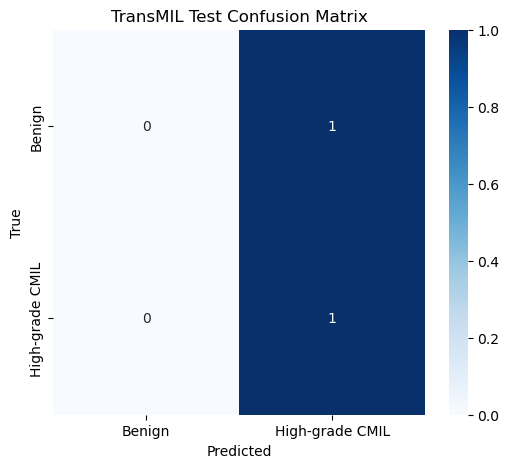

In [10]:
# Test
model.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for X_bag, y in test_loader:
        X_bag = X_bag.to(device)
        y = y.to(device)
        logits = model(X_bag)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_trues.extend(y.cpu().numpy())

# Print classification report
print(classification_report(all_trues, all_preds, target_names=['Benign', 'High-grade CMIL'], labels=[0,1]))

# Plot confusion matrix
cm = confusion_matrix(all_trues, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign','High-grade CMIL'],
            yticklabels=['Benign','High-grade CMIL'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("TransMIL Test Confusion Matrix")
plt.show()

